In [9]:
import sys
sys.path.append("/home/diego/Dropbox/hold_noise/iclamp-glm/")
# import os
import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd
# import seaborn as sns

from icglm.glm_decoding import GLMDecoder
from icglm.glm_fitting import GLMFitter
from icglm.iclamp import IClamp
from icglm.kernels import KernelFun

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from cycler import cycler
import seaborn as sns
size = 24
sns.set(style="ticks", rc={'figure.figsize': (3.5, 3.), 'axes.labelsize': size, 'lines.linewidth': 1.4, 'lines.markersize': 10,
                           'xtick.labelsize': size, 'ytick.labelsize': size, 'errorbar.capsize': 5,
                           'legend.fontsize': size, 'axes.spines.top': False, 'axes.spines.right': False,
                           'axes.prop_cycle': cycler(color=['dodgerblue', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                                                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])})

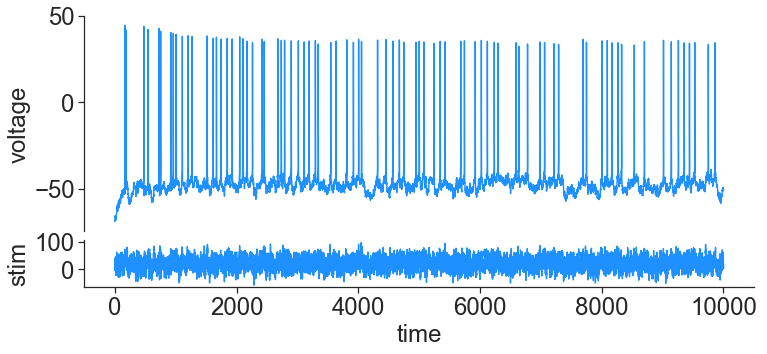

In [21]:
from icglm.iclamp import IClamp
ic = IClamp.load_from_abf(path='./18o03049.abf')
ic = ic.subtract_Ih(th=1000.1).restrict(t0=1000.1, tf=11000.1)
fig, _ = ic.plot(sweeps=[0])
fig.savefig('./ic_plot.png')

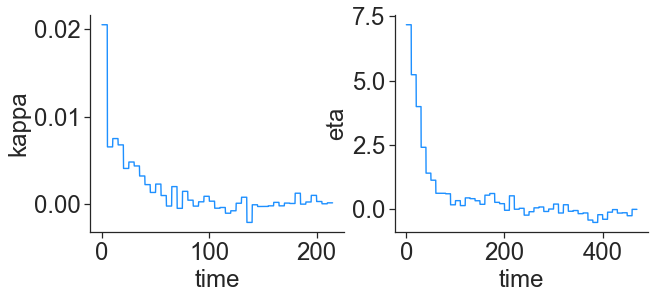

In [15]:
glm_fit = GLMFitter(ic).set_mask_spikes(thr=-13).subsample(10)

tbins_kappa = np.arange(0., 220, 5.)
tbins_eta = np.arange(0., 475., 10.)

glm_fit.fit(tbins_kappa=tbins_kappa, tbins_eta=tbins_eta, verbose=False)
glm_fit.plot_filters()

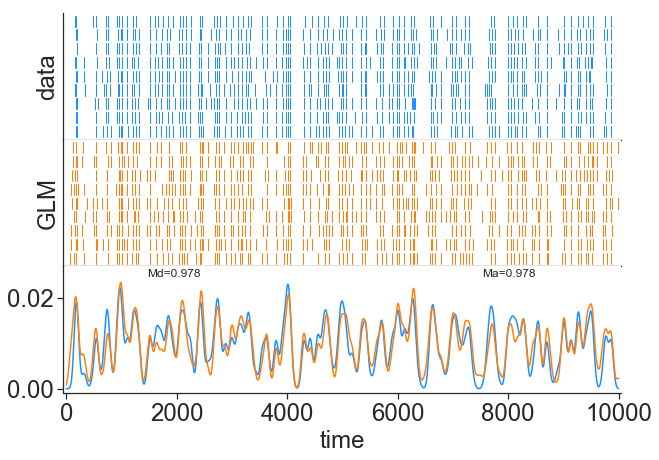

In [16]:
glm_fit.set_mask_spikes_model(trials=9)
glm_fit.psth(psth_kernel=KernelFun.gaussian_delta(delta=40))
glm_fit.plot_raster()

In [17]:
Imu, Isd = np.mean(glm_fit.ic.stim), np.mean(np.std(glm_fit.ic.stim, 0))

I0 = np.zeros(len(glm_fit.ic.t))
decoder = GLMDecoder(glms=[glm_fit.glm], t=glm_fit.ic.t, mask_spk=[glm_fit.mask_spikes], 
                     tau=3, Imu=[Imu], Isd=[Isd], I_true=(glm_fit.ic.stim - Imu) / Isd)

decoder.estimate_MAP_I(I0, prior='OU', verbose=True)

Starting decoding... 

 Finished at 19 of 100 iterations Elapsed time: 15.26 seconds

(<Figure size 720x540 with 5 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x7fd958eb0550>,
   <matplotlib.axes._subplots.AxesSubplot at 0x7fd958ca4278>]))

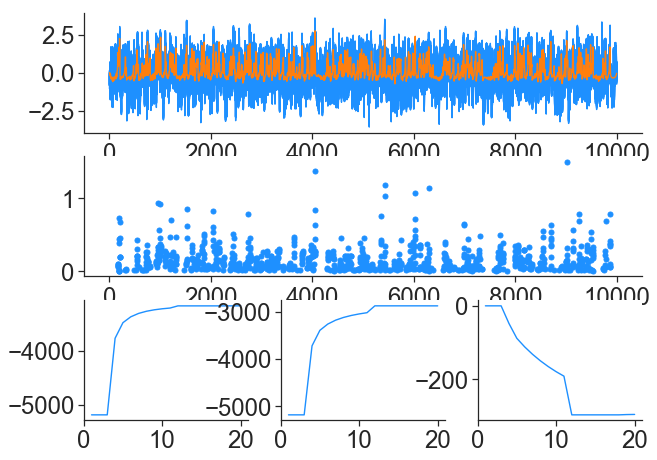

In [18]:
decoder.plot_decoding()